## CS 445: Computational Photography

## Programming Project #3: Gradient Domain Fusion

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from random import random
import time
import scipy
import scipy.sparse.linalg

# modify to where you store your project data including utils.py
datadir = "" 

utilfn = datadir + "utils.py"
if (os.name == "nt"):
    !copy "$utilfn" "utils.py"
else:
    !cp "$utilfn" .
    
samplesfn = datadir + "samples"
#if (os.name == "nt"):
#    !xcopy "$samplesfn" . /E
#else:
#    !cp -r "$samplesfn" .

cp: ./utils.py and utils.py are identical (not copied).


In [3]:
import utils

## Part 1 Toy Problem (20 pts)

In [4]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, 
    but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its 
    gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) 
    and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """    
    # TO DO    
    im_h, im_w = img.shape
    neq =  (im_h * im_w) * 2 + 1 #number of equations
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    b = np.zeros((neq,1),  dtype='double')
    e = -1

    for x in range(im_w):
        for y in range(im_h):
            # First objective
            e = e + 1;
            A[e, im2var[y][x]] = -1
            if (x < im_w - 1): # edges
                A[e, im2var[y][x+1]] = 1
                b[e] = img[y][x+1] - img[y][x]
            else:
                b[e] = - img[y][x]
                
            # Second objective
            e = e + 1;
            A[e, im2var[y][x]] = -1
            if (y < im_h - 1): # edges
                #print(y, im_h)
                A[e, im2var[y + 1][x]] = 1
                b[e] = img[y + 1][x] - img[y][x]
            else:
                b[e] = - img[y][x]    
    
    # Third objective
    e = e + 1;
    A[e, im2var[0][0]] = 1
    b[e] = img[0][0]
   
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)

    # Initialize img_out with the same size and data type as img
    img_out = np.zeros(img.shape,  dtype=img.dtype)
    
    # iterate through the v tuple to copy the pixels to img_out
    i = 0
    for y in range(im_h): 
        for x in range(im_w):
            img_out[y,x] = v[0][i]
            i = i + 1

    return(img_out)

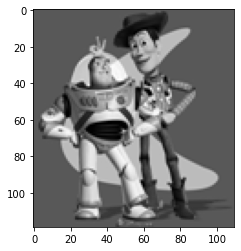

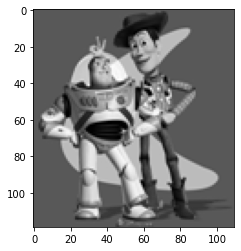

Max error is:  5.079696432985781e-06
Good! Error is smaller than baseline


In [5]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

error_actual = np.sqrt(((im_out - toy_img)**2).max())
error_baseline = 1E-3

if (error_actual < error_baseline):
    print("Good! Error is smaller than baseline")
else:
    print("Not good! Error is greater than baseline")

## Preparation

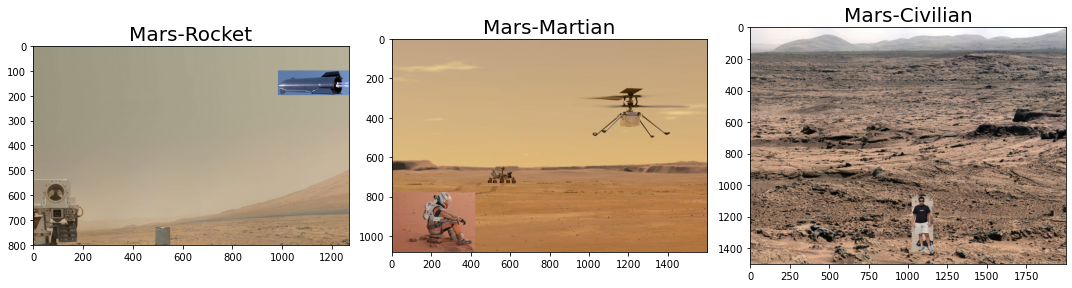

In [6]:
#Prepare Mars-rocket combination
background_img_mars_favorite = cv2.cvtColor(cv2.imread('samples/mars-bg6.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img_mars_favorite = cv2.cvtColor(cv2.imread('samples/starship-object-a.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (1, 286, 286, 1) 
    ys = (3, 3, 102, 102)
    object_mask_mars_favorite = utils.get_mask(ys, xs, object_img_mars_favorite)
    bottom_center_mars_favorite = (1124, 200)
    
    object_img_mars_favorite, object_mask_mars_favorite = utils.crop_object_img(object_img_mars_favorite, object_mask_mars_favorite)
    bg_ul_mars_favorite = utils.upper_left_background_rc(object_mask_mars_favorite, bottom_center_mars_favorite)
    mars_rocket = utils.get_combined_img(background_img_mars_favorite, object_img_mars_favorite, object_mask_mars_favorite, bg_ul_mars_favorite)

# Prepare Mars-astronaut (The Martian) combination
background_img_marsb = cv2.cvtColor(cv2.imread('samples/mars-bg3.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img_marsb = cv2.cvtColor(cv2.imread('samples/mars-object-b.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (2, 422, 422, 2)
    ys = (3, 3, 306, 306)
    object_mask_marsb = utils.get_mask(ys, xs, object_img_marsb)
    bottom_center_marsb = (210, 1083)
    
    object_img_marsb, object_mask_marsb = utils.crop_object_img(object_img_marsb, object_mask_marsb)
    bg_ul_marsb = utils.upper_left_background_rc(object_mask_marsb, bottom_center_marsb)
    mars_astronaut = utils.get_combined_img(background_img_marsb, object_img_marsb, object_mask_marsb, bg_ul_marsb)
    
# Prepare Mars-civilian combination (failure case)
background_img_mars = cv2.cvtColor(cv2.imread('samples/mars-bg.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
object_img_mars = cv2.cvtColor(cv2.imread('samples/mars-object-a3.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (9, 145, 145, 9)
    ys = (8, 8, 360, 360)
    object_mask_mars = utils.get_mask(ys, xs, object_img_mars)
    bottom_center_mars = (1090, 1420)

    object_img_mars, object_mask_mars = utils.crop_object_img(object_img_mars, object_mask_mars)
    bg_ul_mars = utils.upper_left_background_rc(object_mask_mars, bottom_center_mars)
    mars_civilian = utils.get_combined_img(background_img_mars, object_img_mars, object_mask_mars, bg_ul_mars)
    
fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes[0].imshow(mars_rocket) 
axes[0].set_title('Mars-Rocket', fontsize=20) 
axes[1].imshow(mars_astronaut) 
axes[1].set_title('Mars-Martian', fontsize=20) 
axes[2].imshow(mars_civilian)
axes[2].set_title('Mars-Civilian', fontsize=20)
fig.tight_layout()

## Part 2 Poisson Blending (50 pts)

In [7]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO
    im_h, im_w = object_img.shape
    neq =  (im_h * im_w) * 4 #number of equations
    
    nnz = (object_mask > 0).sum()
    im2var = -np.ones(object_img.shape, dtype='int32')
    im2var[object_mask > 0] = np.arange(nnz)

    A = scipy.sparse.lil_matrix((neq, im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq,1),  dtype='double')    
    e = -1

    for y in range(im_h - 1):
        for x in range(im_w - 1):
            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y + 1, x] == 1):
                A[e, im2var[y+1,x]] = -1
                b[e] = object_img[y,x] - object_img[y+1,x]
            else:
                b[e] = object_img[y,x] - object_img[y+1,x] + bg_img[bg_ul[0]+ y +1,bg_ul[1]+x]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y, x + 1] == 1):
                A[e, im2var[y,x+1]] = -1
                b[e] = object_img[y,x] - object_img[y,x+1]
            else:
                #print("x+1")
                b[e] = object_img[y,x] - object_img[y,x+1] + bg_img[bg_ul[0] + y,bg_ul[1]+ x +1]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y - 1, x] == 1):
                A[e, im2var[y-1,x]] = -1                
                b[e] = object_img[y,x] - object_img[y-1,x]
            else:
                b[e] = object_img[y,x] - object_img[y-1,x] + bg_img[bg_ul[0]+ y - 1,bg_ul[1]+ x]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y, x - 1] == 1):
                A[e, im2var[y,x-1]] = -1
                b[e] = object_img[y,x] - object_img[y,x-1]
            else:
                b[e] = object_img[y,x] - object_img[y,x-1] + bg_img[bg_ul[0] + y,bg_ul[1] + x-1]
                    
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)

    # Initialize img_out with the same size and data type as img
    img_out = np.zeros(object_img.shape,  dtype=object_img.dtype)
    
    # iterate through the v tuple to copy the pixels to img_out
    for y in range(im_h): 
        for x in range(im_w):
            img_out[y,x] = v[0][im2var[y,x]]
            
    # Blend img_out into bg_img
    img_blended = bg_img.copy()
    img_blended[bg_ul[0]:bg_ul[0] + im_h, bg_ul[1]:bg_ul[1] + im_w] = img_out

    return img_blended

### Poisson Blending: my favorite result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


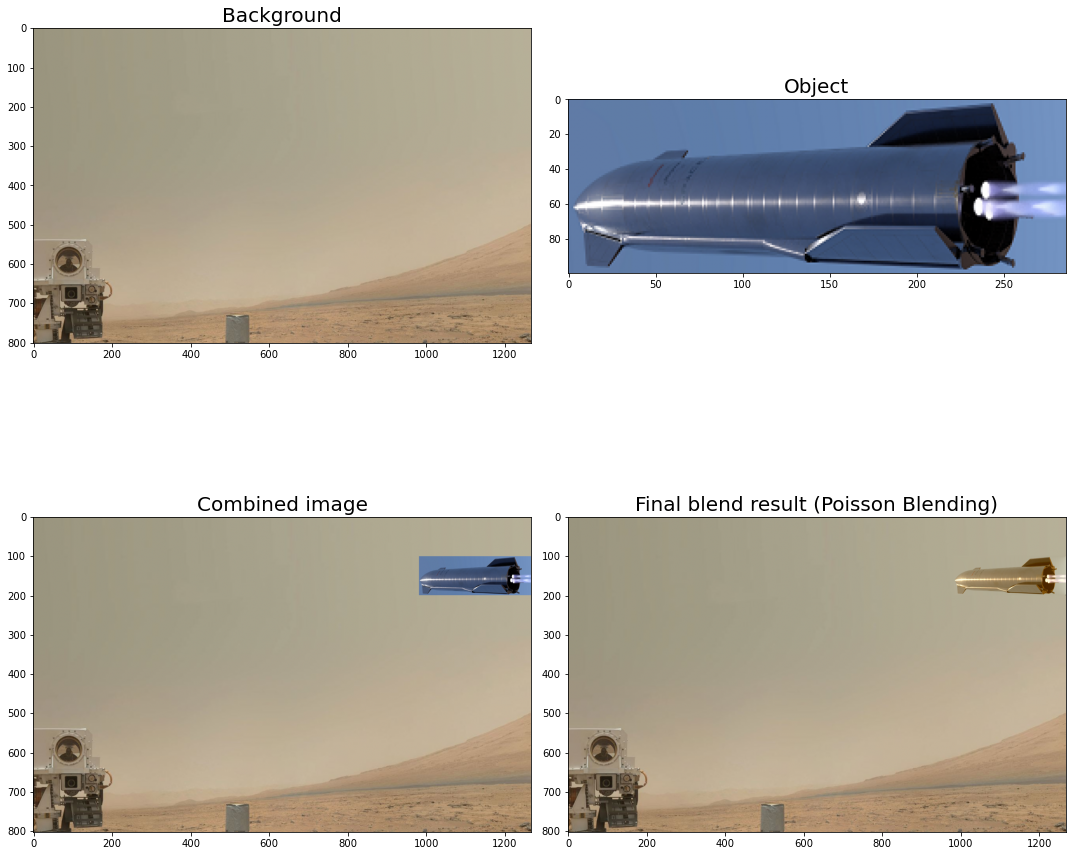

In [8]:
# Poisson blend
im_blend_mars_favorite = np.zeros(background_img_mars_favorite.shape)
for b in np.arange(3):
    im_blend_mars_favorite[:,:,b] = poisson_blend(object_img_mars_favorite[:,:,b], object_mask_mars_favorite, background_img_mars_favorite[:,:,b].copy(), bg_ul_mars_favorite)

# For the report: 
#   (1) background and object images; 
#   (2) pasted image with source pixels directly copied onto target background region (can use utils.get_combined_img);
#   (3) final blend result.

fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes[0,0].imshow(background_img_mars_favorite) 
axes[0,0].set_title('Background', fontsize=20) 
axes[0,1].imshow(object_img_mars_favorite) 
axes[0,1].set_title('Object', fontsize=20) 
axes[1,0].imshow(mars_rocket)
axes[1,0].set_title('Combined image', fontsize=20)
axes[1,1].imshow(im_blend_mars_favorite)
axes[1,1].set_title('Final blend result (Poisson Blending)', fontsize=20)
fig.tight_layout()

### Poisson Blending: another good result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


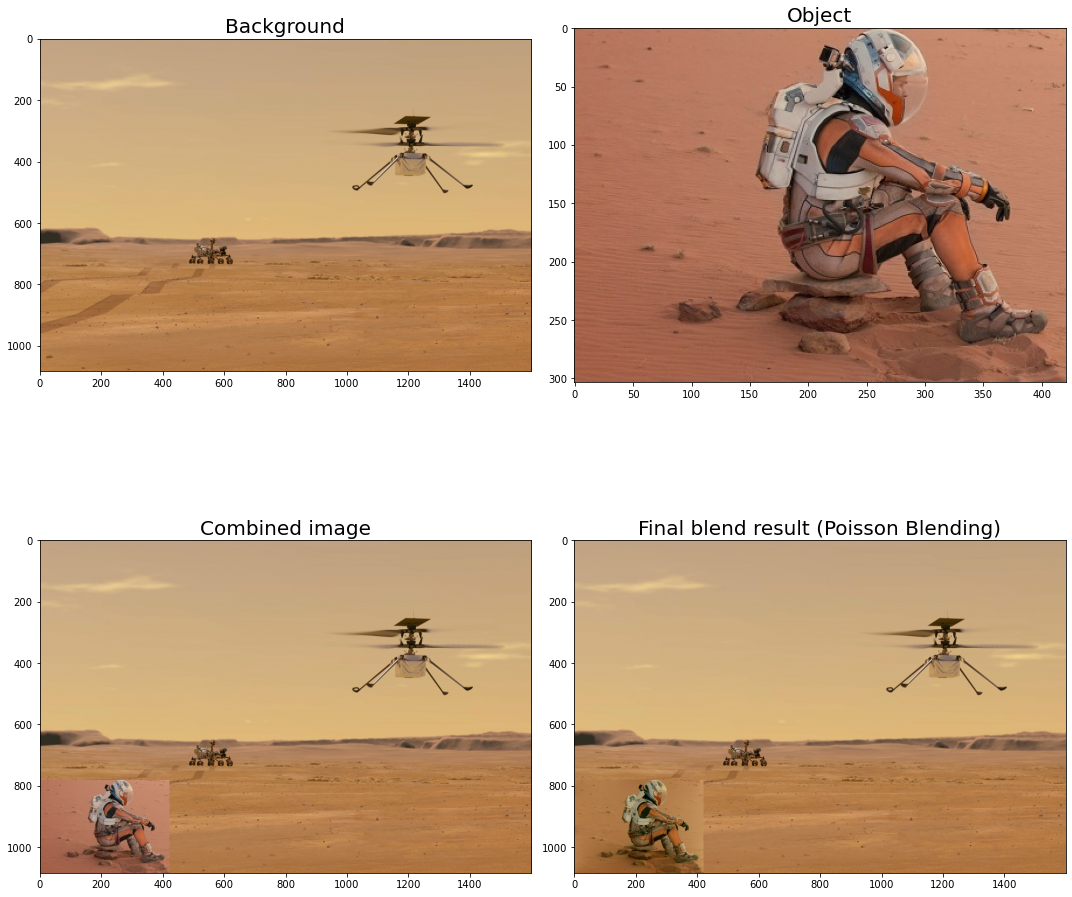

In [9]:
# Poisson blend
im_blend_marsb = np.zeros(background_img_marsb.shape)
for b in np.arange(3):
    im_blend_marsb[:,:,b] = poisson_blend(object_img_marsb[:,:,b], object_mask_marsb, background_img_marsb[:,:,b].copy(), bg_ul_marsb)

fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes[0,0].imshow(background_img_marsb) 
axes[0,0].set_title('Background', fontsize=20) 
axes[0,1].imshow(object_img_marsb) 
axes[0,1].set_title('Object', fontsize=20) 
axes[1,0].imshow(mars_astronaut)
axes[1,0].set_title('Combined image', fontsize=20)
axes[1,1].imshow(im_blend_marsb)
axes[1,1].set_title('Final blend result (Poisson Blending)', fontsize=20)
fig.tight_layout()

### Poisson Blending: failure case

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


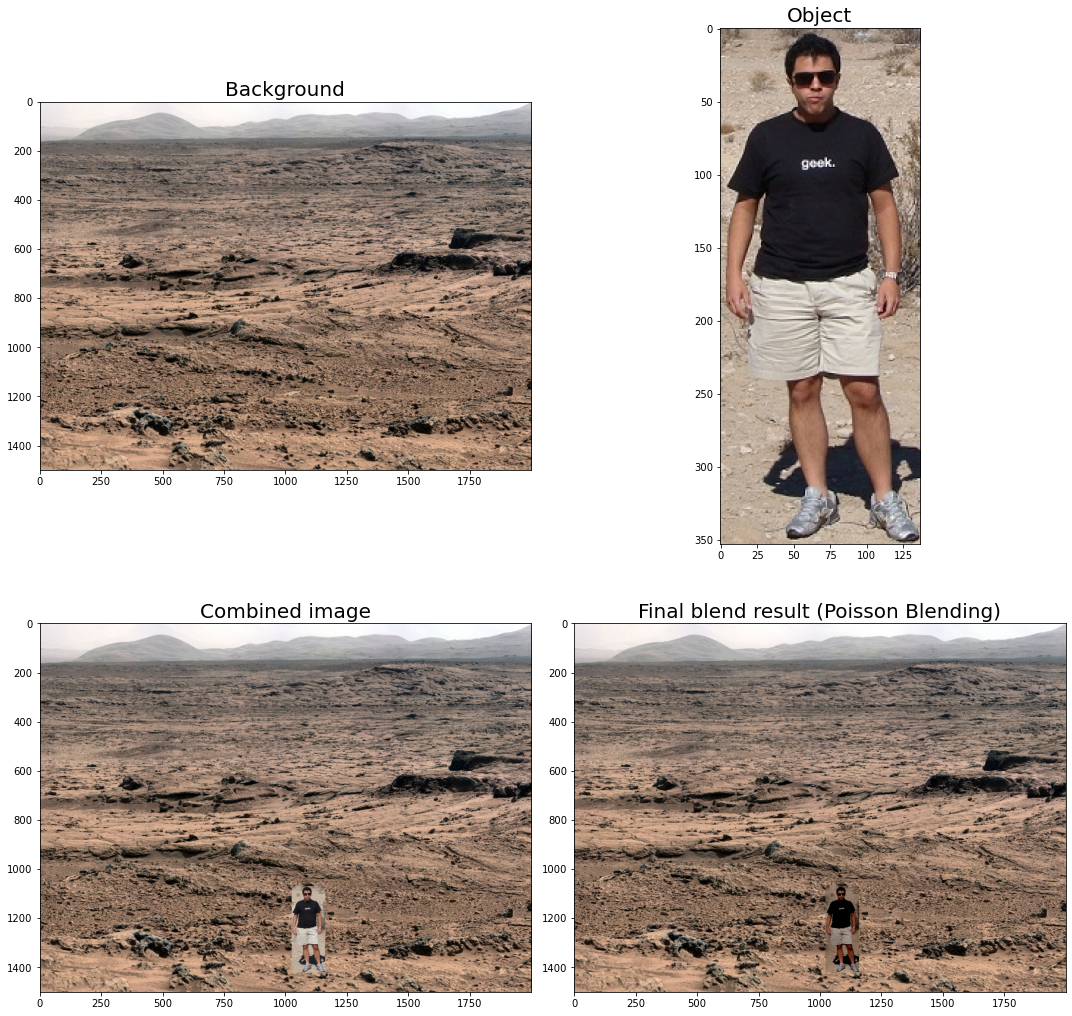

In [10]:
# Poisson blend
im_blend_mars = np.zeros(background_img_mars.shape)
for b in np.arange(3):
    im_blend_mars[:,:,b] = poisson_blend(object_img_mars[:,:,b], object_mask_mars, background_img_mars[:,:,b].copy(), bg_ul_mars)

fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes[0,0].imshow(background_img_mars) 
axes[0,0].set_title('Background', fontsize=20) 
axes[0,1].imshow(object_img_mars) 
axes[0,1].set_title('Object', fontsize=20) 
axes[1,0].imshow(mars_civilian)
axes[1,0].set_title('Combined image', fontsize=20)
axes[1,1].imshow(im_blend_mars)
axes[1,1].set_title('Final blend result (Poisson Blending)', fontsize=20)
fig.tight_layout()

## Part 3 Mixed Gradients (20 pts)

In [11]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO
    im_h, im_w = object_img.shape
    neq =  (im_h * im_w) * 4 #number of equations
    
    nnz = (object_mask > 0).sum()
    im2var = -np.ones(object_img.shape, dtype='int32')
    im2var[object_mask > 0] = np.arange(nnz)

    A = scipy.sparse.lil_matrix((neq, im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq,1),  dtype='double')    
    e = -1

    for y in range(im_h - 1):
        for x in range(im_w - 1):
            # For Mixed Gradient: per Professor Hoiem's comment on Piazza @175_f1
            # if abs(s_i-s_j) > abs(t_i-t_j), b= s_i-s_j; else, b =t_i-t_j  
            if (abs(object_img[y,x] - object_img[y + 1,x]) > abs(bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y + 1, bg_ul[1] + x])):
                gradient = object_img[y,x] - object_img[y + 1,x]
            else:
                gradient = bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y + 1,bg_ul[1] + x]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y + 1, x] == 1):
                A[e, im2var[y+1,x]] = -1
                b[e] = gradient
            else:
                b[e] = gradient + bg_img[bg_ul[0] + y + 1,bg_ul[1]+x]

            if (abs(object_img[y,x] - object_img[y,x + 1]) > abs(bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y, bg_ul[1] + x + 1])):
                gradient = object_img[y,x] - object_img[y,x + 1]
            else:
                gradient = bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y,bg_ul[1] + x + 1]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y, x + 1] == 1):
                A[e, im2var[y,x+1]] = -1
                b[e] = gradient
            else:
                b[e] = gradient + bg_img[bg_ul[0] + y,bg_ul[1]+ x + 1]

            if (abs(object_img[y,x] - object_img[y - 1,x]) > abs(bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y - 1, bg_ul[1] + x])):
                gradient = object_img[y,x] - object_img[y - 1,x]
            else:
                gradient = bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y - 1,bg_ul[1] + x]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y - 1, x] == 1):
                A[e, im2var[y-1,x]] = -1                
                b[e] = gradient
            else:
                b[e] = gradient + bg_img[bg_ul[0]+ y - 1,bg_ul[1]+ x]

            if (abs(object_img[y,x] - object_img[y,x - 1]) > abs(bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y, bg_ul[1] + x - 1])):
                gradient = object_img[y,x] - object_img[y,x - 1]
            else:
                gradient = bg_img[bg_ul[0] + y,bg_ul[1] + x] - bg_img[bg_ul[0] + y,bg_ul[1] + x - 1]

            e += 1;
            A[e, im2var[y,x]] = 1
            if (object_mask[y, x - 1] == 1):
                A[e, im2var[y,x-1]] = -1
                b[e] = gradient
            else:
                b[e] = gradient + bg_img[bg_ul[0] + y,bg_ul[1] + x - 1]
                
    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)

    # Initialize img_out with the same size and data type as img
    img_out = np.zeros(object_img.shape,  dtype=object_img.dtype)
    
    # iterate through the v tuple to copy the pixels to img_out
    for y in range(im_h): 
        for x in range(im_w):
            img_out[y,x] = v[0][im2var[y,x]]
            
    # Blend img_out into bg_img
    img_blended = bg_img.copy()
    img_blended[bg_ul[0]:bg_ul[0] + im_h, bg_ul[1]:bg_ul[1] + im_w] = img_out

    return img_blended

### Mixed gradients: favorite result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


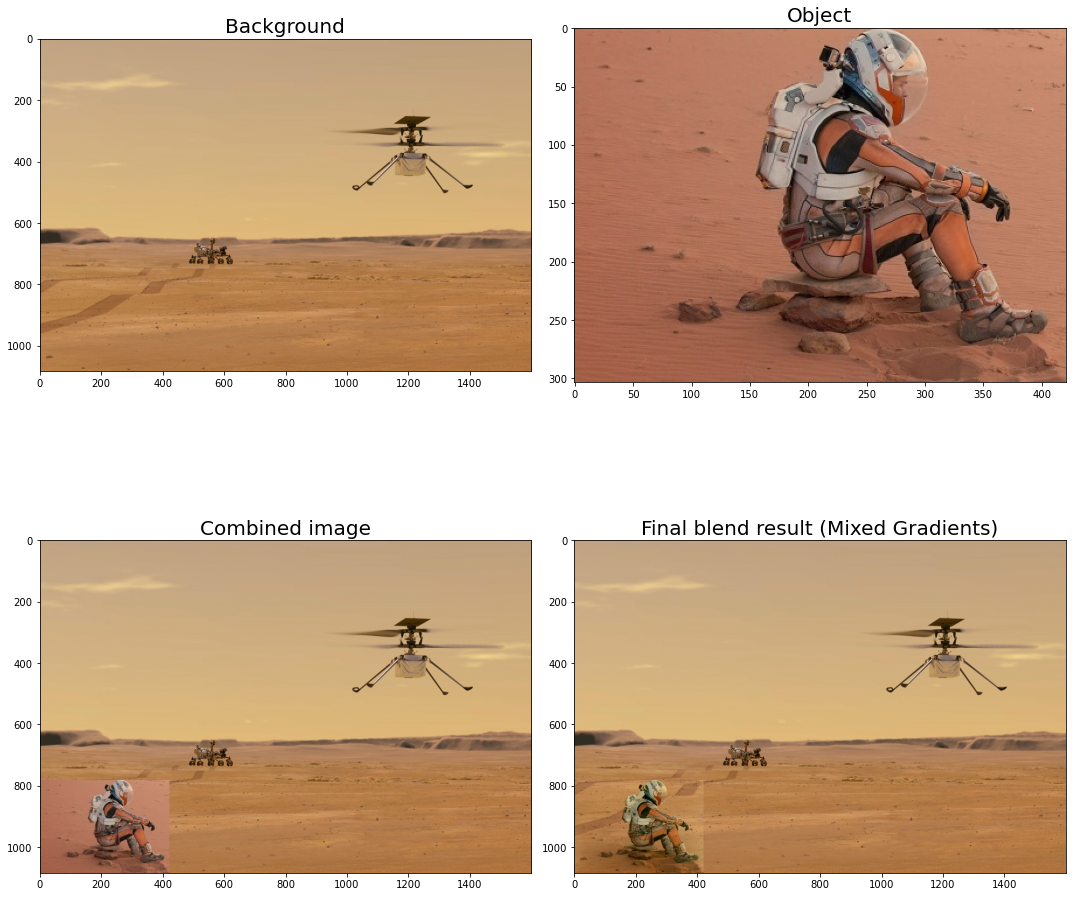

In [12]:
# Mixed gradients
im_blend_marsb_mixed = np.zeros(background_img_marsb.shape)
for b in np.arange(3):
    im_blend_marsb_mixed[:,:,b] = mixed_blend(object_img_marsb[:,:,b], object_mask_marsb, background_img_marsb[:,:,b].copy(), bg_ul_marsb)

fig, axes = plt.subplots(2, 2, figsize=(15,15))
axes[0,0].imshow(background_img_marsb) 
axes[0,0].set_title('Background', fontsize=20) 
axes[0,1].imshow(object_img_marsb) 
axes[0,1].set_title('Object', fontsize=20) 
axes[1,0].imshow(mars_astronaut)
axes[1,0].set_title('Combined image', fontsize=20)
axes[1,1].imshow(im_blend_marsb_mixed)
axes[1,1].set_title('Final blend result (Mixed Gradients)', fontsize=20)
fig.tight_layout()

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [13]:
def color2gray(img):
    im_h, im_w, im_channels = img.shape
    neq = (im_h * im_w) * 4 + 1 #number of equations

    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    A = scipy.sparse.lil_matrix((neq, im_h * im_w), dtype='double') # init lil
    b = np.zeros((neq,1),  dtype='double')    
    e = -1
    
    e =+ 1
    A[e, im2var[0,0]] = 1
    b[e] = 0
    
    for y in range(im_h - 1):
        for x in range(im_w - 1):
            red = img[y,x,0] - img[y+1,x,0]
            green = img[y,x,1] - img[y+1,x,1]
            blue = img[y,x,2] - img[y+1,x,2]
            
            e += 1;
            A[e, im2var[y,x]] = 1
            A[e, im2var[y+1,x]] = -1
            
            if (abs(red) > max(abs(green),abs(blue))):
                b[e] = red
            elif (abs(green) > max(abs(red),abs(blue))):
                b[e] = green
            else:
                b[e] = blue
                
            if (y > 0):
                red = img[y,x,0] - img[y-1,x,0]
                green = img[y,x,1] - img[y-1,x,1]
                blue = img[y,x,2] - img[y-1,x,2]

                e += 1;
                A[e, im2var[y,x]] = 1
                A[e, im2var[y-1,x]] = -1
                if (abs(red) > max(abs(green),abs(blue))):
                    b[e] = red
                elif (abs(green) > max(abs(red),abs(blue))):
                    b[e] = green
                else:
                    b[e] = blue                

            red = img[y,x,0] - img[y,x+1,0]
            green = img[y,x,1] - img[y,x+1,1]
            blue = img[y,x,2] - img[y,x+1,2]
            
            e += 1;
            A[e, im2var[y,x]] = 1
            A[e, im2var[y,x+1]] = -1
            
            if (abs(red) > max(abs(green),abs(blue))):
                b[e] = red
            elif (abs(green) > max(abs(red),abs(blue))):
                b[e] = green
            else:
                b[e] = blue
                
            if (x > 0):
                red = img[y,x,0] - img[y,x-1,0]
                green = img[y,x,1] - img[y,x-1,1]
                blue = img[y,x,2] - img[y,x-1,2]

                e += 1;
                A[e, im2var[y,x]] = 1
                A[e, im2var[y,x-1]] = -1

                if (abs(red) > max(abs(green),abs(blue))):
                    b[e] = red
                elif (abs(green) > max(abs(red),abs(blue))):
                    b[e] = green
                else:
                    b[e] = blue

    v = scipy.sparse.linalg.lsqr(A.tocsr(), b)

    # Initialize img_gray with the same size and data type as img
    img_gray = np.zeros(img.shape,  dtype=img.dtype)
    
    # iterate through the v tuple to copy the pixels to img_out
    for y in range(im_h): 
        for x in range(im_w):
            img_gray[y,x] = v[0][im2var[y,x]]
            
    return img_gray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


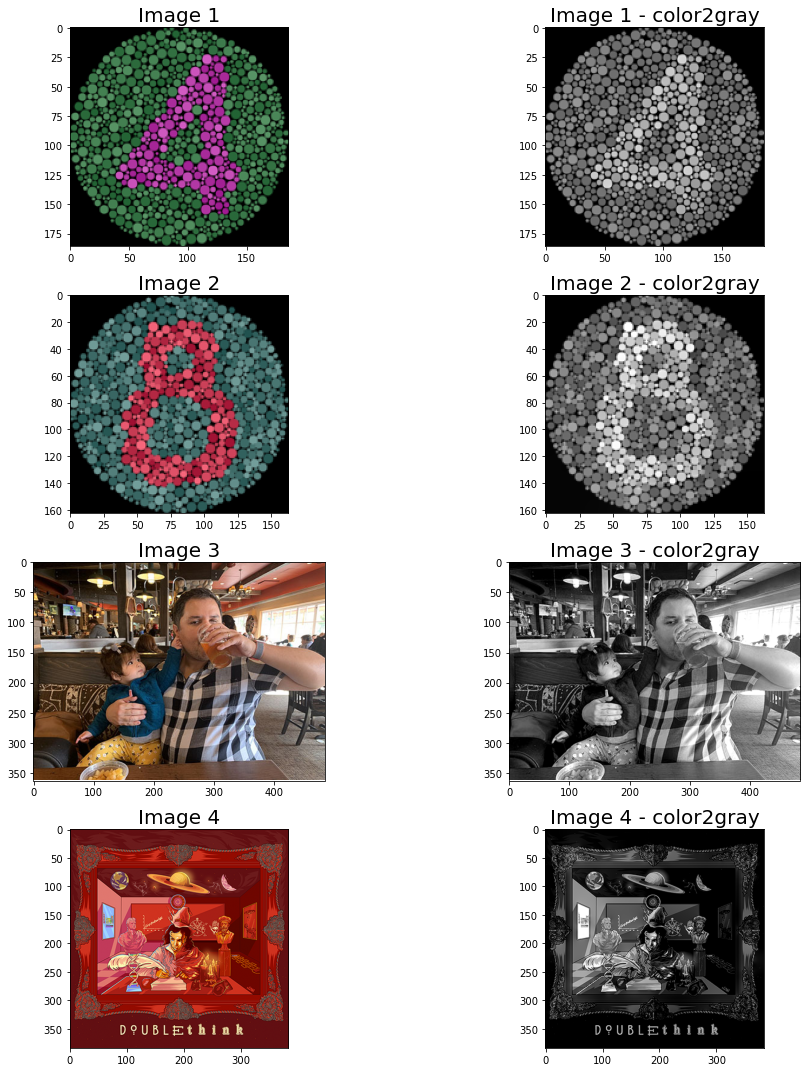

In [14]:
colorBlind4_img = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
colorBlind8_img = cv2.cvtColor(cv2.imread('samples/colorBlind8.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
diner_img = cv2.cvtColor(cv2.imread('samples/diner.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
album_cover_img = cv2.cvtColor(cv2.imread('samples/doublethink.png'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 

gray_colorBlind4_img = color2gray(colorBlind4_img)
gray_colorBlind8_img = color2gray(colorBlind8_img)
gray_diner_img = color2gray(diner_img)
gray_album_cover_img = color2gray(album_cover_img)

fig, axes = plt.subplots(4, 2, figsize=(15,15))
axes[0,0].imshow(colorBlind4_img) 
axes[0,0].set_title('Image 1', fontsize=20) 
axes[0,1].imshow(gray_colorBlind4_img) 
axes[0,1].set_title('Image 1 - color2gray', fontsize=20) 
axes[1,0].imshow(colorBlind8_img)
axes[1,0].set_title('Image 2', fontsize=20)
axes[1,1].imshow(gray_colorBlind8_img)
axes[1,1].set_title('Image 2 - color2gray', fontsize=20)
axes[2,0].imshow(diner_img)
axes[2,0].set_title('Image 3', fontsize=20)
axes[2,1].imshow(gray_diner_img)
axes[2,1].set_title('Image 3 - color2gray', fontsize=20)
axes[3,0].imshow(album_cover_img)
axes[3,0].set_title('Image 4', fontsize=20)
axes[3,1].imshow(gray_album_cover_img)
axes[3,1].set_title('Image 4 - color2gray', fontsize=20)
fig.tight_layout()

## Laplacian pyramid blending (20 pts)

In [15]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
    pass

## More gradient domain processing (up to 20 pts)

# Appendix: blending results with the sample image

For debugging purposes and to allow verification of the implementation of the algorithms, please see below the result of implementing the blending techniques using the provided sample images. 

## Preparation

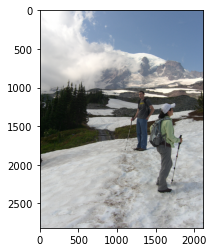

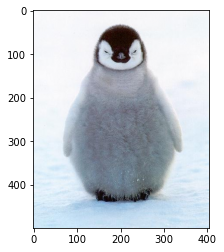

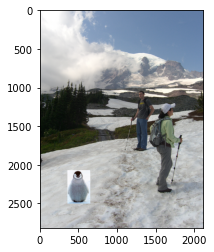

In [16]:
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = False  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
    xs = (65, 359, 359, 65)
    ys = (24, 24, 457, 457)
    object_mask = utils.get_mask(ys, xs, object_img)
    bottom_center = (500, 2500) # (x,y)
    
    object_img, object_mask = utils.crop_object_img(object_img, object_mask)
    bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
    plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Poisson Blending

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


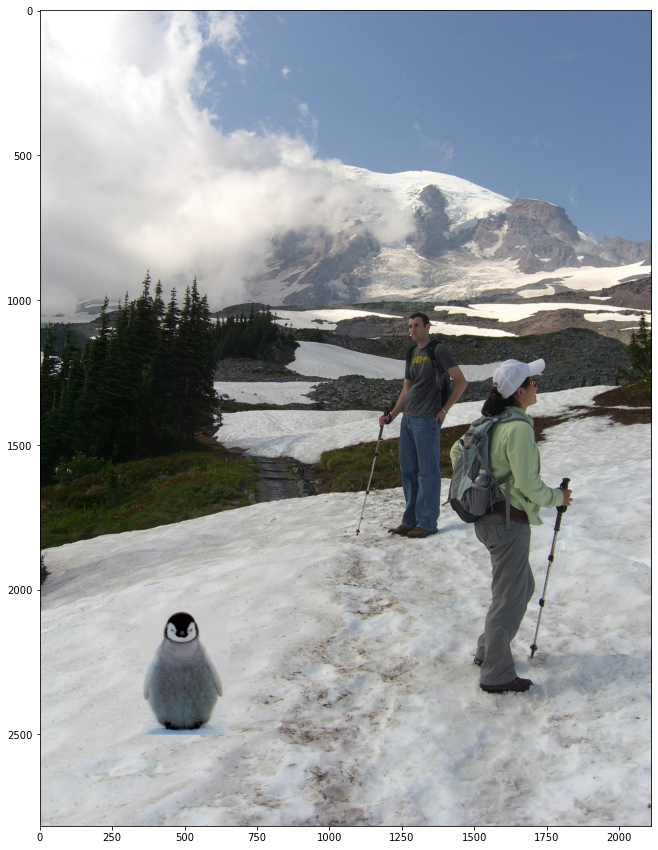

In [17]:
im_blend = np.zeros(background_img.shape)
for b in np.arange(3):
    im_blend[:,:,b] = poisson_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_blend) 

## Mixed Blending

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


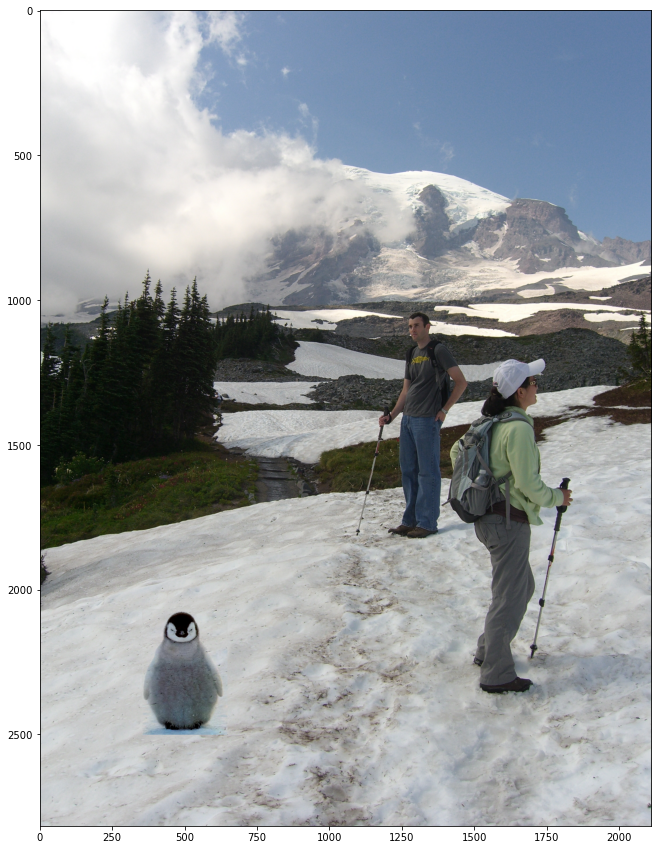

In [18]:
im_mix = np.zeros(background_img.shape)

for b in np.arange(3):
    im_mix[:,:,b] = mixed_blend(object_img[:,:,b], object_mask, background_img[:,:,b].copy(), bg_ul)

plt.figure(figsize=(15,15))
plt.imshow(im_mix)